# Stationary Navier-Stokes Equations
We are solving the Stationary Navier-Stokes equation:
\begin{align*}
   u\cdot\nabla u - \nu\Delta u + \nabla p &= 0 \\
                             \nabla\cdot u &= 0
\end{align*}
with $\nu = \frac{1}{\mathit{Re}}$, where $\nu$ is the viscocity and $\mathit{Re}$ is the Reynolds number. The variational formulation of the above equation is:
\begin{align*}
   \left(v, u\cdot\nabla u\right) + \nu\left(\nabla v, \nabla u\right) - \left(\nabla\cdot v, p\right) &= 0 \;\;\;\; \forall v \in H_{0}^{1} \\
                                                                               \left(v, \nabla\cdot u\right) &= 0 \;\;\;\; \forall q \in L^{2}
\end{align*}

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square

import numpy as np
import scipy.sparse as sp
from scipy.linalg import cholesky
from scipy.sparse.linalg import svds, spsolve
import matplotlib.pyplot as plt

import time

importing NGSolve-6.2.2204


## Newton's Method for the nonlinearity
For the nonlinearity we used Newton's Iteration Method:

- Given an initial guess $u^{0}$
- loop over $i=0,...$ until gonvergence
    - Compute Linearization $Au^{i} + \delta A(u^{i})\Delta u^{i} = 0$
        - $f_{i} = Au^{i}$
        - $B^{i} = \delta A(u^{i})$
        - Solve $B^{i}\Delta u^{i} = -f^{i}$
    - Update $u^{i+1} = u^{i} + \Delta u^{i}$
    - Evaluate stopping criteria

As a stopping criteria we take $\langle Au^{i},\; \Delta u^{i}\rangle = \langle Au^{i},\; Au^{i}\rangle_{(B^{i})^{-1}} < \varepsilon$

In [2]:
def SimpleNewtonSolve(gfu, a, tol=1e-12, maxits=25):
    res = gfu.vec.CreateVector()
    du = gfu.vec.CreateVector()
    fes = gfu.space
    for it in range(maxits):
        print ("Iteration {:3}  ".format(it),end="")
        a.Apply(gfu.vec, res)
        a.AssembleLinearization(gfu.vec)
        du.data = a.mat.Inverse(fes.FreeDofs()) * res
        gfu.vec.data -= du
        stopcritval = sqrt(abs(InnerProduct(du,res)))
        print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
        if stopcritval < tol:
            break

## Function for generating data
We solve the equation for certain values of Reynolds number inside a given parameter range $(\mathit{Re}_{a},\;\mathit{Re}_{b})$. During this phase (called offline-phase) we compute a sequence of representative solutions (called snapshots) $(u_{i})_{1}^{N_{sn}}$ for a given Reynolds number $\mathit{Re}_{i}$.

In [3]:
def nvst(h, deg, Re, filename):
    nu = Parameter(1/Re)
    snap_dict = dict()
    
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    
    V = VectorH1(mesh, order=deg, dirichlet="bottom|right|top|left")
    Q = H1(mesh, order=deg-1)
    N = NumberSpace(mesh)
    X = V*Q*N
    (u,p,lam), (v,q,mu) = X.TnT()
    
    a = BilinearForm(X)
    a += (nu*InnerProduct(grad(u), grad(v)) + InnerProduct(grad(u)*u, v) - div(v)*p - div(u)*q - lam*q - mu*p)*dx
    
    gfu = GridFunction(X)
    uh = gfu.components[0]
    snaps = np.zeros([61, uh.vec.size])
    
    count = 0
    
    start = time.time()
    while Re <= 151:
        print(f'nu is {nu}')
        gfu.components[0].Set(CoefficientFunction((4*x*(1-x),0)), definedon=mesh.Boundaries("top"))
        SimpleNewtonSolve(gfu, a)
        snaps[count,:] = uh.vec.data
        
        if count in [10,20,30,40,50,60]:
            end = time.time()
            total_time = end - start
            print("count is "+str(count)+" ex.time is "+str(total_time))
        
        count += 1
        Re += 2.5
        nu.Set(1/Re)
    
    snap_dict['NSE_nu'] = snaps.T
    np.savez(filename+'.npz', **snap_dict)
    
    return 'data generated'

## Class which manages the ROM

In [4]:
class MyROM:
    def __init__(self, h, deg):
        
        '''
        Defines mesh and FE space.  Computes mass matrix.
        '''
        
        self.mesh = Mesh(unit_square.GenerateMesh(maxh=h))
        self.V = VectorH1(self.mesh, order=deg, dirichlet="bottom|right|top|left")
        
        u,v = self.V.TnT()
        mass = BilinearForm(self.V, symmetric=True)
        mass += SymbolicBFI(InnerProduct(u,v))
        mass.Assemble()
        rows, cols, vals = mass.mat.COO()
        self.M = sp.csr_matrix((vals, (rows, cols)))
        self.M.shape
        
    def load_data_from_file(self, file, nSnaps):
        
        '''
        Loads snapshots from file and computes center component-wise.
        
        Outputs:  u -- [2n, nSnaps] array of stacked velocity components.
                  ubar -- [2n, 1] array of corresponding means.
        '''
        
        self.u = np.load(file, allow_pickle=True)[:,-nSnaps:]
        n = int(self.u.shape[0]/2)
        self.ubar = np.concatenate((np.mean(self.u[:n], axis=1),
                                    np.mean(self.u[n:], axis=1)),
                                  axis=0).reshape(-1,1)
        self.nSnaps = nSnaps
        self.u.shape
        self.ubar.shape
        
    def load_data_from_array(self, array, nSnaps):
        
        '''
        Loads snapshots from array and computes center component-wise.
        '''
        
        self.u = array[:,-nSnaps:]
        n = int(self.u.shape[0]/2)
        self.ubar = np.concatenate((np.mean(self.u[:n],axis=1),
                                   np.mean(self.u[n:], axis=1)),
                                   axis=0).reshape(-1,1)
        self.nSnaps = nSnaps
        
    def generate_POD_basis(self, numBasis):
        
        '''
        Generates POD basis from snapshot data.
        
        Inputs:   numBasis -- number of singular vectors to compute.
        
        Outputs:  POD -- [2n, numBasis] array of singular vectors.
                  ews -- length numBasis array of largest singular values in descending order.
        '''
        
        R = cholesky(self.M.todense())
        RuTilde = R @ (self.u - self.ubar)
        U, S, _ = svds(RuTilde, k=numBasis, which='LM')
        U = np.flip(U, axis=1)
        self.ews = np.flip(S)
        self.POD = spsolve(R, U[:,:numBasis])
        print(f'POD basis of size {numBasis} has been generated')
        
    def plot_evals(self, n):
        
        '''
        Plots magnitude of first n eigenvalues.
        '''
        
        x = np.array([i+1 for i,e in enumerate(self.ews)])[:n]
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(x, self.ews[:n])
        ax.set_yscale('log')
        plt.show()
        
    def project(self, u, n):
        
        '''
        Projects full-order object to reduced space of size n.
        '''
        
        return self.POD[:,:n].T @ self.M @ (u - self.ubar)
    
    def reconstruct(self, a):
        
        '''
        Reconstructs full-order object from reduced-order one.
        '''
        
        return self.ubar + self.POD[:,:a.shape[0]] @ a
    
    def compute_L2_error(self, approx):
        
        '''
        Computes relative L2 error between snapshots and approximation.
        '''
        
        diff = self.u - approx
        num2 = np.trace(diff.T @ self.M @ diff)
        den2 = np.trace(self.u.T @ self.M @ self.u)
        return np.sqrt(num2/den2)
    
    def test_POD_projection(self):
        
        '''
        Tests the convergence of the computed POD basis.
        '''
        
        for dim in [2**i for i in range(5)]:
            percent_energy = (np.sum(self.ews[:dim]**2)
                              /np.sum(self.ews**2)*100)
            aa = self.project(self.u, dim)
            projRecon = self.reconstruct(aa)
            error = self.compute_L2_error(projRecon)
            print(f'dim is {dim}, % energy is {percent_energy:.3f}, '
                 + f'and compression error is {error:.7f}')
            
    def assemble(self, dim, nu):
        
        '''
        Assembles the right-hand side (RHS) of the NSE-ROM.
        Must be called after POD basis has been generated.
        
        Inputs:   dim -- reduced basis dimension.
                  nu -- viscosity in NSE
        
        Outputs:  [self.r{i} for i in range(3)] representing the
                  rank i terms of the RHS computed in terms of the
                  POD basis. Respective sizes are [dim], [dim,dim],
                  and [dim,dim,dim].
        '''
        
        self.dim = dim
        u, v = self.V.TnT()

        ubarG = GridFunction(self.V)
        ubarG.vec.FV().NumPy()[:] = self.ubar.flatten()

        uguC = ubarG.vec.CreateVector()
        uguC = Grad(ubarG)*ubarG

        rank1 = LinearForm(self.V)
        rank1 += SymbolicLFI(InnerProduct(uguC, v)
                             + nu*InnerProduct(Grad(ubarG)+Grad(ubarG).trans, Grad(v)))
        rank1.Assemble()

        rank2 = BilinearForm(self.V)
        rank2 += SymbolicBFI(InnerProduct(Grad(ubarG)*u+Grad(u)*ubarG, v) 
                             + nu*InnerProduct(Grad(u)+Grad(u).trans, Grad(v)))
        rank2.Assemble()
        rows, cols, vals = rank2.mat.COO()
        rank2Mat = sp.csr_matrix((vals, (rows, cols)))
                                  
        rank3 = [0 for b in range(dim)]
        rank3Mat = [0 for b in range(dim)]
        for b in range(dim):
            phibG = GridFunction(self.V)
            phibG.vec.FV().NumPy()[:] = self.POD[:,b]
            rank3[b] = BilinearForm(self.V)
            rank3[b] += SymbolicBFI(InnerProduct(Grad(u)*phibG, v))
            rank3[b].Assemble()
            rows, cols, vals = rank3[b].mat.COO()
            rank3Mat[b] = sp.csr_matrix((vals, (rows, cols)))

        self.r1 = self.POD[:,:dim].T @ rank1.vec.FV().NumPy()[:]
        self.r2 = self.POD[:,:dim].T @ rank2Mat.T @ self.POD[:,:dim]
        self.r3 = np.array([self.POD[:,:dim].T @ rank3Mat[b].T @ self.POD[:,:dim]
                            for b in range(dim)])
                                
    def integrate_fEuler(self, l, N, nSub):
        
        '''
        Forward Euler integration of the ROM system.
        
        Inputs:   l -- length of step
                  N -- number of steps
                  nSub -- parameter controlling the substepping.
                  
        Outputs:  a -- [dim, N] array containing the reduced solution.
        '''
        
        Ns = self.u.shape[1]
        a = np.zeros([self.dim, N])
        a[:,0] = (self.u[:,Ns-N]-self.ubar.flatten()) @ self.M @ self.POD[:,:self.dim]
        for i in range(1, N):
            aOld = a[:,i-1]
            for j in range(nSub):
                rhsn = np.dot(aOld, self.r2) + np.dot(aOld, np.dot(aOld, self.r3))
                aOld = aOld - l / nSub * (rhsn + self.r1)
            a[:,i] = aOld
        self.a = a
    
    def test_ROM_approximation(self, nu, nSub):
        
        '''
        Tests the convergence of the computed ROM approximation.
        '''
                                  
        for dim in [2**i for i in range(5)]:
            percent_energy = (np.sum(self.ews[:dim]**2) 
                              / np.sum(self.ews**2) * 100)
            
            self.assemble(dim, nu)
            self.integrate_fEuler(0.05, self.nSnaps, nSub)
            uTilde = self.reconstruct(self.a)
            error = self.compute_L2_error(uTilde)
            print(f'dim is {dim}, % energy is {percent_energy:.3f}, '
                  + f'and prediction error is {error:.7f}')

## Testing
Reynolds number 101, P3/P2 elements. Snapshots within the range $(\mathit{Re}_{first}=1,\mathit{Re}_{last}=151)$.

In [5]:
nvst(0.05, 3, 1, 'stokes')
repo = np.load('stokes.npz')
snaps = repo['NSE_nu']
rom = MyROM(0.05, 3)
rom.load_data_from_array(snaps, 61)

nu is ParameterCF, val = 1

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  2.79707497096098
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.00793910369659443
Iteration   2  <A u 2 , A u 2 >_{-1}^0.5 =  6.512315424048464e-08
Iteration   3  <A u 3 , A u 3 >_{-1}^0.5 =  9.25442106944447e-16
nu is ParameterCF, val = 0.285714

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  1.7849216032330943
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.014849022336830938
Iteration   2  <A u 2 , A u 2 >_{-1}^0.5 =  1.4920153341530968e-06
Iteration   3  <A u 3 , A u 3 >_{-1}^0.5 =  1.714552137884664e-14
nu is ParameterCF, val = 0.166667

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  1.2552029029365779
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.019432388384094206
Iteration   2  <A u 2 , A u 2 >_{-1}^0.5 =  5.73705888520665e-06
Iteration   3  <A u 3 , A u 3 >_{-1}^0.5 =  5.702430398331378e-13
nu is ParameterCF, val = 0.117647

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  1.0386819356999324
Iteration   1  <A u 1 , A u 

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  0.3886262477119278
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.057109425318867
Iteration   2  <A u 2 , A u 2 >_{-1}^0.5 =  0.0015605495195509479
Iteration   3  <A u 3 , A u 3 >_{-1}^0.5 =  1.5720318652867507e-06
Iteration   4  <A u 4 , A u 4 >_{-1}^0.5 =  1.4905854573896588e-12
Iteration   5  <A u 5 , A u 5 >_{-1}^0.5 =  1.2941742766074753e-16
nu is ParameterCF, val = 0.0163934

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  0.38057582435715104
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.058035632169765365
Iteration   2  <A u 2 , A u 2 >_{-1}^0.5 =  0.0017203235612950685
Iteration   3  <A u 3 , A u 3 >_{-1}^0.5 =  2.0397921338804692e-06
Iteration   4  <A u 4 , A u 4 >_{-1}^0.5 =  2.697424530829053e-12
Iteration   5  <A u 5 , A u 5 >_{-1}^0.5 =  1.280772153846602e-16
nu is ParameterCF, val = 0.015748

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  0.3730097181637631
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.058919697023305316
Iteration   2  

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  0.28899195591882326
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.06898793346050665
Iteration   2  <A u 2 , A u 2 >_{-1}^0.5 =  0.005735275525500114
Iteration   3  <A u 3 , A u 3 >_{-1}^0.5 =  5.1860257630737105e-05
Iteration   4  <A u 4 , A u 4 >_{-1}^0.5 =  5.094032415577626e-09
Iteration   5  <A u 5 , A u 5 >_{-1}^0.5 =  1.215212942280828e-16
nu is ParameterCF, val = 0.00921659

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  0.28566810439402607
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.06935694565514416
Iteration   2  <A u 2 , A u 2 >_{-1}^0.5 =  0.006002910149531137
Iteration   3  <A u 3 , A u 3 >_{-1}^0.5 =  5.889770586114026e-05
Iteration   4  <A u 4 , A u 4 >_{-1}^0.5 =  6.7905669077971065e-09
Iteration   5  <A u 5 , A u 5 >_{-1}^0.5 =  1.426682401172164e-16
nu is ParameterCF, val = 0.00900901

Iteration   0  <A u 0 , A u 0 >_{-1}^0.5 =  0.28245778049014836
Iteration   1  <A u 1 , A u 1 >_{-1}^0.5 =  0.06970725993349954
Iteration   2 

In [6]:
start1 = time.time()
rom.generate_POD_basis(16)
end1 = time.time()
total_time1 = end1 - start1
print("\n" + str(total_time1))

/home/paschalis/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


POD basis of size 16 has been generated

24.2594313621521


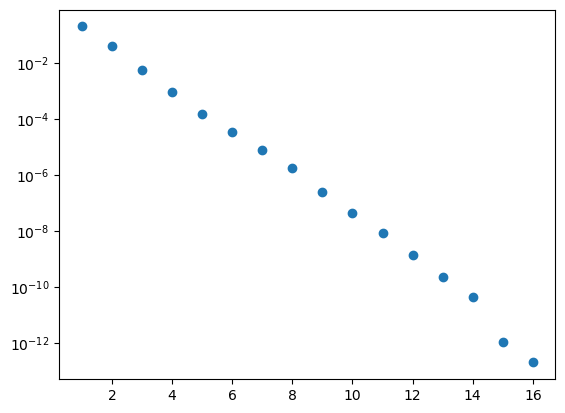

In [7]:
rom.plot_evals(16)

In [8]:
rom.test_POD_projection()

dim is 1, % energy is 96.052, and compression error is 0.0232494
dim is 2, % energy is 99.924, and compression error is 0.0032223
dim is 4, % energy is 100.000, and compression error is 0.0000898
dim is 8, % energy is 100.000, and compression error is 0.0000001
dim is 16, % energy is 100.000, and compression error is 0.0000000


In [9]:
rom.test_ROM_approximation(99e-4, 16)

dim is 1, % energy is 96.052, and prediction error is 0.0734205
dim is 2, % energy is 99.924, and prediction error is 0.0773318
dim is 4, % energy is 100.000, and prediction error is 0.0790192
dim is 8, % energy is 100.000, and prediction error is 0.0781678
dim is 16, % energy is 100.000, and prediction error is 0.0778539


In [10]:
start3 = time.time()
aaa = rom.project(rom.u ,2)
rom.reconstruct(aaa)
end3 = time.time()
total_time3 = end3 - start3
print("\ntotal time is "+str(total_time3))


total time is 0.0057713985443115234


In [11]:
start2 = time.time()
rom.assemble(2, 99e-4)
rom.integrate_fEuler(0.025, 61, 16)
uTilde = rom.reconstruct(rom.a)
end2 = time.time()
total_time2 = end2 - start2
print("\ntotal time is "+str(total_time2))


total time is 0.1041254997253418


In [12]:
gfut = GridFunction(rom.V, multidim=0)
for i,col in enumerate(snaps.T[::10]):
    gfut.AddMultiDimComponent(col[:11466])
Draw (gfut, rom.mesh, interpolate_multidim=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

In [13]:
gfut = GridFunction(rom.V, multidim=0)
for i,col in enumerate(uTilde.T[::10]):
    gfut.AddMultiDimComponent(col[:11466])
Draw (gfut, rom.mesh, interpolate_multidim=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene